**Machine Learning for Time Series (Master MVA)**

- TP5, Friday 12<sup>th</sup> March 2021
- [Link to the class material.](http://www.laurentoudre.fr/ast.html)

# Introduction

In this notebook, we illustrate the following concept:
- change point detection.

## Setup

**Import**

In [153]:
import datetime as dt
from math import log

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ruptures as rpt
from IPython.display import Audio, display
from loadmydata.load_uea_ucr import load_uea_ucr_data
from matplotlib.dates import DateFormatter
from ruptures.base import BaseCost
from ruptures.metrics import hausdorff
from scipy.stats import ttest_ind

**Utility functions**

In [154]:
def fig_ax(nrows=1, figsize=(15, 3)):
    return plt.subplots(nrows=nrows, figsize=(figsize[0], figsize[1] * nrows))

# Change point detection

Change point detection consists in finding the temporal boundaries of homogeneous portions of a signal.

## Mean shift detection

The simplest (and oldest) change point detection method deals with mean shifts.

### Single change point

We start by trying to detect a single shift in mean (in a synthetic signal).

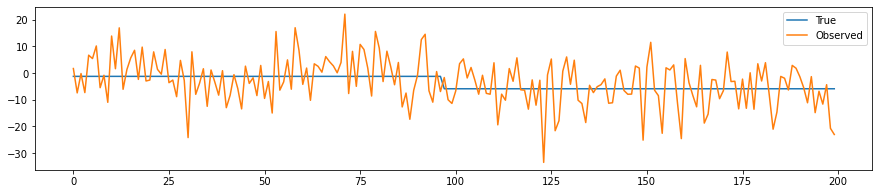

In [155]:
# generate signal
n_samples = 200
n_bkps = 1
n_dims = 1
sigma_noise = 8
signal, bkps = rpt.pw_constant(
    n_samples=n_samples, n_features=n_dims, n_bkps=n_bkps, noise_std=0
)
signal_with_noise = signal + np.random.normal(
    scale=sigma_noise, size=signal.shape
)

fig, ax = fig_ax()
ax.plot(signal, label="True")
ax.plot(signal_with_noise, label="Observed")
_ = plt.legend()

We fit the noisy signal with a piecewise constant function with a single discontinuity. The best fit is the function which minimizes the norm of the residuals.

For a $T$-sample signal $y$ and an index $a$, this amounts to:

$$
\sum_{t< a} \|y_t-\bar{y}_{0..a}\|^2 + \sum_{t\geq a} \|y_t-\bar{y}_{a..T}\|^2
$$

where $\bar{y}_{\text{left}}$ and $\bar{y}_{\text{right}}$ are the empirical means of $\{y_0,\dots,y_{a-1}\}$ and $\{y_a,\dots,y_{T-1}\}$ respectively.

The detection procedure consists in finding the index $a$ that minimizes this sum of costs.

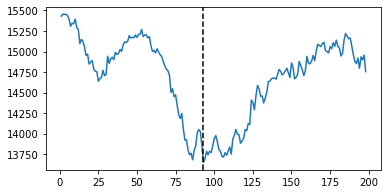

In [156]:
sum_of_cost_list = list()

admissible_change_points = np.arange(1, n_samples - 1)

for mid_point in admissible_change_points:
    sum_of_cost = signal_with_noise[
        :mid_point
    ].var() * mid_point + signal_with_noise[mid_point:].var() * (
        n_samples - mid_point
    )
    sum_of_cost_list.append(sum_of_cost)

fig, ax = fig_ax(figsize=(6, 3))
ax.plot(admissible_change_points, sum_of_cost_list)

# take the minimum sum of costs
detected_change_point = admissible_change_points[np.argmin(sum_of_cost_list)]

# add a vertical dashed line
ax.axvline(detected_change_point, ls="--", color="k")

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What happens to the sum of costs when the noise varies?</p>
    <p>And when the number of samples increases?</p>
</div>

<span style="color:red"> Plus on a d'échantillons, plus c'est précis. 

<span style="color:red"> De plus, plus le bruit est fort, moins on est précis

To check if a change point is indeed present, let us do a t-test between the left part of the signal and the right part of the signal.

In [157]:
ttest_ind(
    signal_with_noise[:detected_change_point],
    signal_with_noise[detected_change_point:],
)

Ttest_indResult(statistic=array([5.11928284]), pvalue=array([7.23854527e-07]))

At first sight, the detected change seems to be statistically significant.

However, let us test this procedure on a pure noise signal.

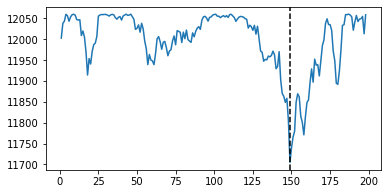

In [158]:
pure_noise = np.random.normal(scale=sigma_noise, size=signal.shape)

sum_of_cost_list = list()

admissible_change_points = np.arange(1, n_samples - 1)
for mid_point in admissible_change_points:
    sum_of_cost = pure_noise[:mid_point].var() * mid_point + pure_noise[
        mid_point:
    ].var() * (n_samples - mid_point)
    sum_of_cost_list.append(sum_of_cost)

fig, ax = fig_ax(figsize=(6, 3))
ax.plot(admissible_change_points, sum_of_cost_list)

# take the minimum sum of costs
detected_change_point = admissible_change_points[np.argmin(sum_of_cost_list)]

# add a vertical dashed line
ax.axvline(detected_change_point, ls="--", color="k")

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Perform a t-test as before. Is there a change point?</p>
    <p>What went wrong?</p>
</div>

In [159]:
ttest_ind(
    signal_with_noise[:detected_change_point],
    signal_with_noise[detected_change_point:],
)

Ttest_indResult(statistic=array([3.22569736]), pvalue=array([0.0014703]))

<span style="color:red"> La p-valeur a augmenté. Le test dépend des données, on a un biais de sélection. 
Il faut fixer l'hypothèse qu'on veut tester avant de regarder les données, sinon on a un biais de sélection. 

We will introduce later a criterion to assess the presence of a change.

### Multiple change points (known $K$)

To extend the detection to more than one change, we simply some the costs of each segment defined by the $K$ change points $t_1,\dots,t_K$:

$$
\sum_{t=0}^{t_1-1} \|y_t-\bar{y}_{0..t_1}\|^2 + \sum_{t=t_1}^{t_2-1} \|y_t-\bar{y}_{t_1..t_2}\|^2 + \dots + \sum_{t=t_K}^{T-1} \|y_t-\bar{y}_{t_K..T}\|^2.
$$

We minimize over the $t_k$, using dynamic programming. (Other methods exists, e.g. binary segmentation, bottom-up, window-based, but are only approximate.)

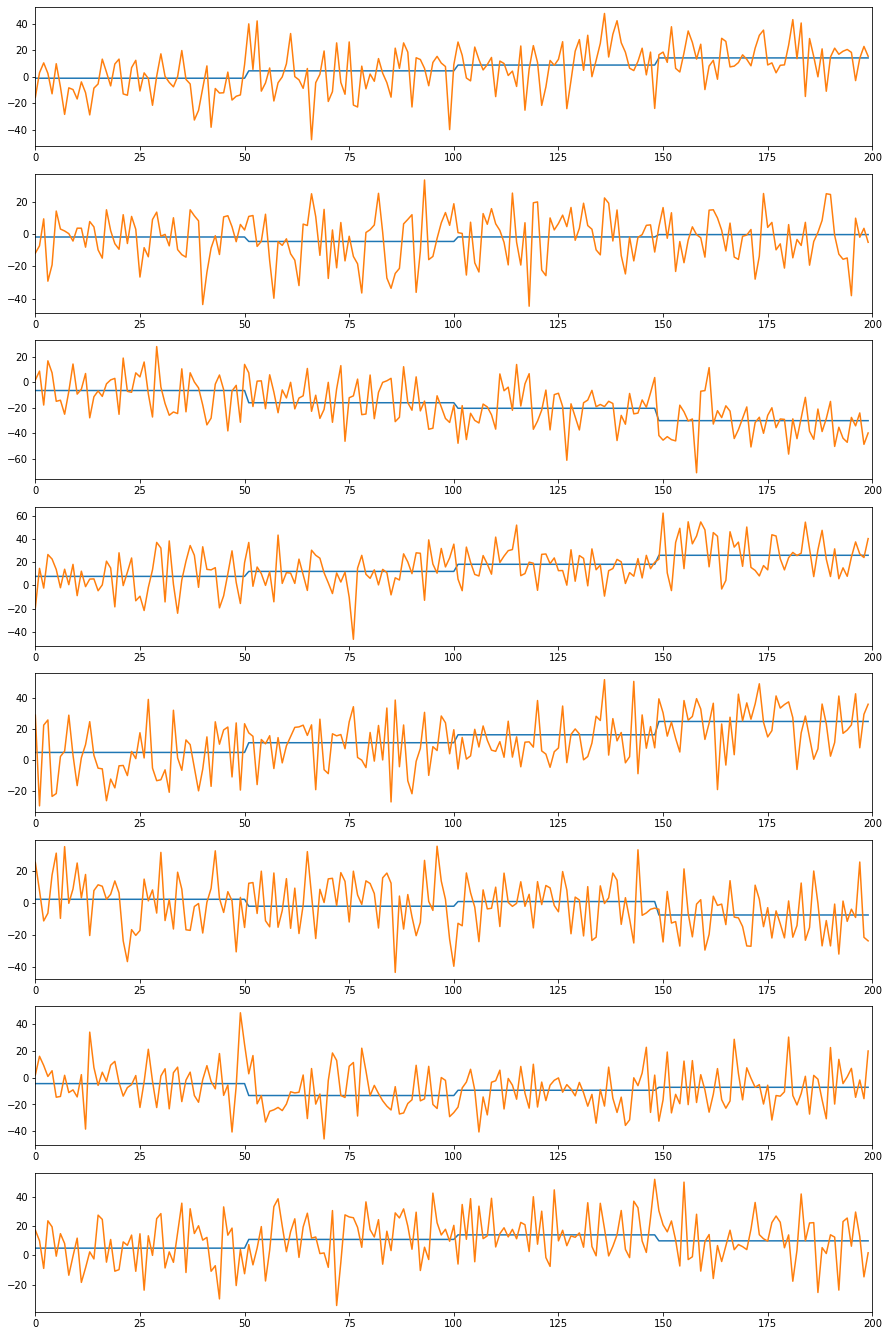

In [160]:
# generate signal
n_samples = 200
n_bkps = 3
n_dims = 8
sigma_noise = 15
signal, bkps = rpt.pw_constant(
    n_samples=n_samples, n_features=n_dims, n_bkps=n_bkps, noise_std=0
)
signal_with_noise = signal + np.random.normal(
    scale=sigma_noise, size=signal.shape
)

# display
fig, ax_arr = fig_ax(nrows=n_dims)
for (signal1d, signal1d_with_noise, ax) in zip(
    signal.T, signal_with_noise.T, ax_arr
):
    ax.plot(signal1d)
    ax.plot(signal1d_with_noise)
    ax.set_xlim(0, n_samples)

Perform change point detection using dynamic programming.

In [161]:
algo = rpt.Dynp(model="l2", jump=1).fit(signal_with_noise)

error: 15.0 samples


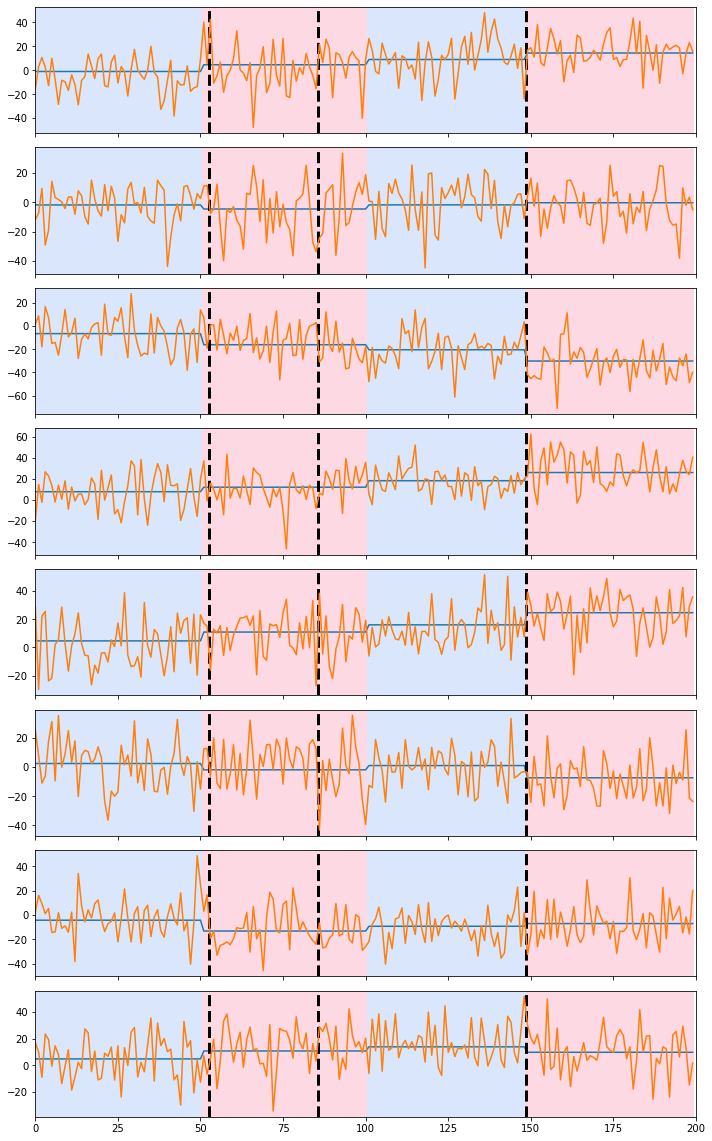

In [162]:
predicted_bkps = algo.predict(n_bkps=n_bkps)

fig, ax_arr = rpt.display(signal, bkps, predicted_bkps)
for (signal1d_with_noise, ax) in zip(signal_with_noise.T, ax_arr):
    ax.plot(signal1d_with_noise)
    ax.set_xlim(0, n_samples)

print(f"error: {hausdorff(bkps, predicted_bkps)} samples")

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Increase the dimension (you can turn off the display). What do you observe?</p>
</div>

<span style="color:red"> La précision augmente. Ceci est du au fait que les dimensions rajoutées sont toutes informatives. 

Intuitively, a change is visible if $\|\delta\| / \|\epsilon\|$ is large where $\delta$ is the mean-shift amplitude and $\epsilon$ the noise.
A Gaussian vector has norm close to $\sqrt{d}\sigma$ and here $\|delta\| = d$ where $d$ is the dimension.
This is the same reason why sphere volume / cube volume goes to zero when the dimension grows.

### Penalized change point detection (unknown $K$)

When the number of changes $K$, we can perform penalized detection:

$$
\min_{K, t_1,\dots,t_K} \left[ \left(\sum_k \sum_{t=t_k}^{t_{k+1}-1} \|y_t-\bar{y}_{t_k..t_{k+1}}\|^2 \right) + \beta K \right]
$$

when $\beta>0$ controls the trade-off between the data fidelity and the complexity of the segmentation.

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>When the regularization parameter increases, do we detect more or less changes?</p>
</div>

<span style="color:red">On detecte moins de changement. En effet, intuitivement, si $\beta$ est très grand, alors l'algorithme essaira de trouver K très petit.  

This formulation generalizes a number of model selection criterion, for instance the well-known BIC criterion: $\beta_{\text{BIC}}=2\sigma^2\log(T)\times(d+1)$ where $T$ is the number of samples and $d$ is the dimension.

For the previous piecewise constant univariate signal example, we can use BIC (with one and zero change) to asses the presence of a change.

In [163]:
# generate signal
n_samples = 200
n_bkps = 1
n_dims = 1
sigma_noise = 5
signal, bkps = rpt.pw_constant(
    n_samples=n_samples, n_features=n_dims, n_bkps=n_bkps, noise_std=0
)
signal_with_noise = signal + np.random.normal(
    scale=sigma_noise, size=signal.shape
)


sum_of_cost_list = list()

admissible_change_points = np.arange(1, n_samples - 1)
for mid_point in admissible_change_points:
    sum_of_cost = signal_with_noise[
        :mid_point
    ].var() * mid_point + signal_with_noise[mid_point:].var() * (
        n_samples - mid_point
    )
    sum_of_cost_list.append(sum_of_cost)


penalized_sum_of_cost_1_change = (
    min(sum_of_cost_list) + 2 * sigma_noise ** 2 * np.log(n_samples) * 2
)

penalized_sum_of_cost_0_change = signal_with_noise.var() * n_samples

print(f"BIC with one change: {penalized_sum_of_cost_1_change:.2f}")
print(f"BIC with zero change: {penalized_sum_of_cost_0_change:.2f}")

if penalized_sum_of_cost_0_change > penalized_sum_of_cost_1_change:
    print("There is one change.")
else:
    print("There is no change.")

BIC with one change: 5449.88
BIC with zero change: 8022.21
There is one change.


<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Do the same with the pure noise signal.</p>
</div>

In [164]:
penalized_sum_of_cost_1_change = (
    min(sum_of_cost_list) + 2 * sigma_noise ** 2 * np.log(n_samples) * 2
)
print('test ', penalized_sum_of_cost_1_change)
penalized_sum_of_cost_0_change = signal.var() * n_samples

print(f"BIC with one change: {penalized_sum_of_cost_1_change:.2f}")
print(f"BIC with zero change: {penalized_sum_of_cost_0_change:.2f}")

if penalized_sum_of_cost_0_change > penalized_sum_of_cost_1_change:
    print("There is one change.")
else:
    print("There is no change.")

test  5449.877849790671
BIC with one change: 5449.88
BIC with zero change: 2968.09
There is no change.


Let us apply the BIC criterion on multivariate signal with several changes.

In [165]:
# generate signal
n_samples = 1000
n_bkps = 3
n_dims = 10
sigma_noise = 15
signal, bkps = rpt.pw_constant(
    n_samples=n_samples, n_features=n_dims, n_bkps=n_bkps, noise_std=0
)
signal_with_noise = signal + np.random.normal(
    scale=sigma_noise, size=signal.shape
)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Compute the regularization parameter (beta) in the following cell, for the signal <tt>signal_with_noise</tt>.</p>
</div>

In [168]:
pen_bic = 2 * sigma_noise**2* log(n_samples)*(n_dims+1)
print('pen bic : ', pen_bic)

pen bic :  34193.38863096158


Penalized change point detection is performed with PELT.

error: 252.0 samples


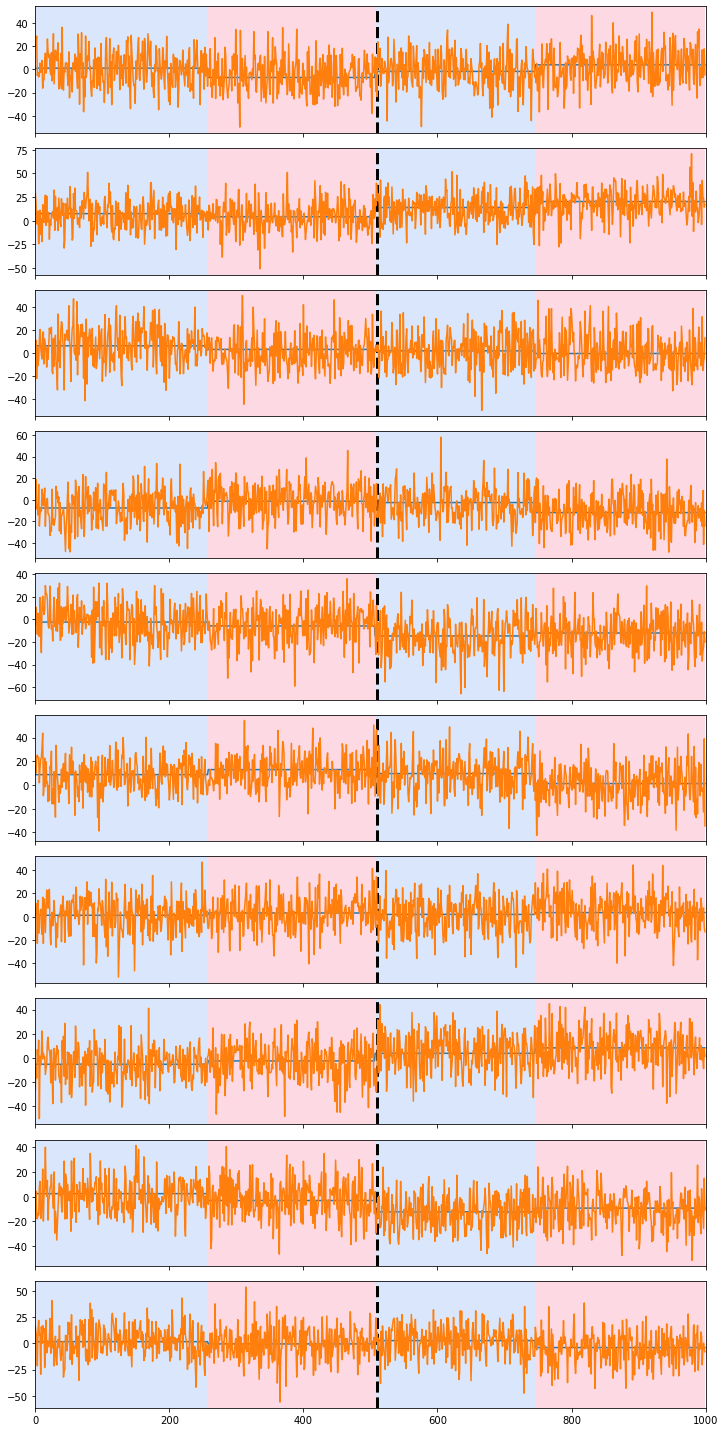

In [169]:
predicted_bkps = rpt.Pelt(model="l2", jump=1).fit_predict(
    signal=signal_with_noise, pen=pen_bic
)

fig, ax_arr = rpt.display(signal, bkps, predicted_bkps)
for (signal1d_with_noise, ax) in zip(signal_with_noise.T, ax_arr):
    ax.plot(signal1d_with_noise)
    ax.set_xlim(0, n_samples)

print(f"error: {hausdorff(bkps, predicted_bkps)} samples")

## General distribution change (parametric)

By setting the cost function to the negative max log likelihood, we can detect any (parametric) distribution change.

$$
c(y_{a..b}) = -\max_\theta\log L(y_{a..b}, \theta)
$$

where $L(\cdot, \theta)$ is the likelihood of a distribution parametrized by $\theta$.


**Example of a Poisson distribution $\mathcal{P}(\lambda)$:** $P_{\lambda}(y_t=k) = \lambda^k e^{-\lambda} / k!$.

The signal is assumed to be piecewise i.i.d. In this setting, we have

$$
L(y_{a..b}, \lambda) = \prod_{t=a}^{b-1} \lambda^{y_t} e^{-\lambda} / y_t!.
$$

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Given the probabily mass function and the maximum likelihood estimator of the intensity parameter, derive the associated cost function.</p>
</div>

<span style="color:red">
    On a $$ g(\lambda) = logL(y_{a...b},\lambda) = \sum_{t = a} ^{b-1} y_tlog(\lambda)-\lambda-log(y_t)$$

<span style="color:red">$g$ étant concave en $\lambda$ car somme d'une fonction linéaire et du log qui est concave, il suffit d'annuler le gradient. 

$$\frac{\partial{g}}{\partial{\lambda}} = \sum_{t = a} ^{b-1} \frac{y_t}{\lambda}-(b-a)  $$

En annulant ceci, on trouve : $$\lambda _{EMV} = \frac{1}{b-a}\sum_{t = a} ^{b-1} y_t$$

We can define a cost function that can be used in `Dynp` and `Pelt`.

In [174]:
class PoissonCost(BaseCost):

    """Custom cost for piecewise Poisson signals."""

    # The 2 following attributes must be specified for compatibility.
    model = "Poisson"
    min_size = 10

    def fit(self, signal):
        """Set the internal parameter."""
        self.signal = signal
        return self

    def error(self, start, end):
        """Return the approximation cost on the segment [start:end].

        Args:
            start (int): start of the segment
            end (int): end of the segment

        Returns:
            float: segment cost
        """
        sub = self.signal[start:end]
        lambda_hat = sub.mean() + 1e-6
        return lambda_hat * (end - start) - log(lambda_hat) * sub.sum()

Generate a piecewise Poison process.

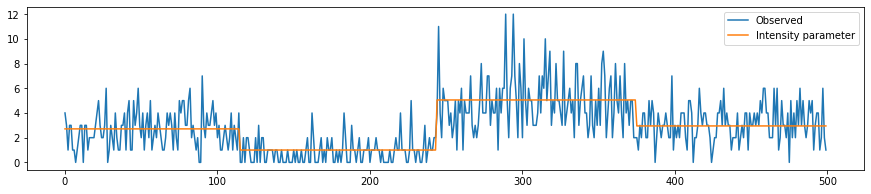

In [175]:
# generate signal
n_samples = 500
n_bkps = 3
n_dims = 1
pwc_constant_signal, bkps = rpt.pw_constant(
    n_samples=n_samples,
    n_features=n_dims,
    n_bkps=n_bkps,
    noise_std=0,
    delta=(1, 5),
)
# shift to make strictly positive
pwc_constant_signal -= pwc_constant_signal.min() - 1

pwc_poisson_signal = np.random.poisson(pwc_constant_signal)

fig, ax = fig_ax()
ax.plot(pwc_poisson_signal, label="Observed")
ax.plot(pwc_constant_signal, label="Intensity parameter")
_ = plt.legend()

Change detection with known number of changes.

In [176]:
detected_bkps = rpt.Dynp(custom_cost=PoissonCost()).fit_predict(
    pwc_poisson_signal, n_bkps=3
)

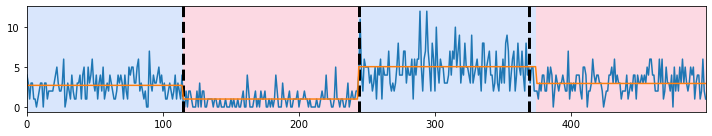

In [177]:
fig, (ax,) = rpt.display(pwc_poisson_signal, bkps, detected_bkps)
ax.plot(pwc_constant_signal)
_ = ax.set_xlim(0, n_samples - 1)

For the Poisson cost function, the BIC criterion is $\beta_{\text{BIC, Poisson}} = (K\log T)/2 $.

In [178]:
bic = log(n_samples) / 2
detected_bkps = rpt.Pelt(custom_cost=PoissonCost()).fit_predict(
    pwc_poisson_signal, pen=bic
)

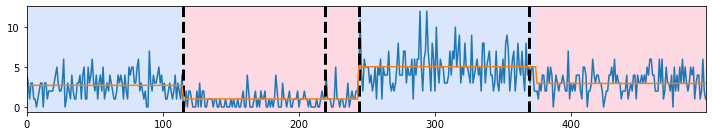

In [179]:
fig, (ax,) = rpt.display(pwc_poisson_signal, bkps, detected_bkps)
ax.plot(pwc_constant_signal)
_ = ax.set_xlim(0, n_samples - 1)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What are known limitations of the BIC criterion?</p>
</div>

<span style="color:red">  Si on ne connait pas la paramétrisation des donnéees, ce sera faux. 
<span style="color:red">  De plus, si on a peu d'échantillons, on fait une grosse erreur 

# Experiments

In [180]:
dataset_name = "DodgerLoopGame"
data = load_uea_ucr_data(dataset_name)
print(data.description)

# DodgersLoop dataset

The traffic data are collected with the loop sensor installed on ramp for the 101 North freeway in Los Angeles. This location is close to Dodgers Stadium; therefore the traffic is affected by volumne of visitors to the stadium.

We make three datasets out of these data.

## DodgersLoopDay

The classes are days of the week.

- Class 1: Sunday
- Class 2: Monday
- Class 3: Tuesday
- Class 4: Wednesday
- Class 5: Thursday 
- Class 6: Friday
- Class 7: Saturday 

Train size: 78

Test size: 80

Number of classes: 7

Missing value: Yes

Time series length: 288

Missing values are represented with NaN.

## DodgersLoopWeekend

- Class 1: Weekday
- Class 2: Weekend

Train size: 20

Test size: 138

Number of classes: 2

Missing value: Yes

Time series length: 288

Missing values are represented with NaN.

## DodgersLoopGame

- Class 1: Normal day
- Class 2: Game day

Train size: 20

Test size: 138

Number of classes: 2

Missing value: Yes

Time series length: 288

There is 

Plot the traffic on a normal day.

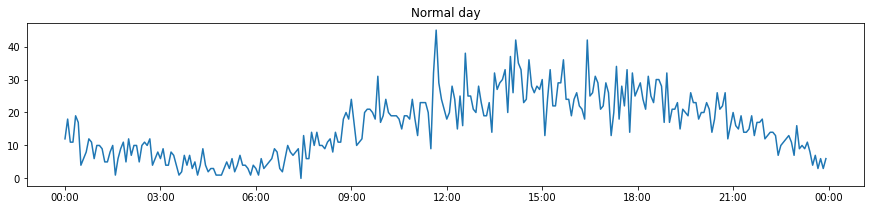

In [181]:
ind = 2

signal = data.X_train[ind]
label = int(data.y_train[ind])

time_index = pd.date_range("00:00", "23:59", freq="5min")

fig, ax = fig_ax()
ax.plot(time_index, signal)
myFmt = DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(myFmt)
_ = ax.set_title(f"{'Game day' if label==2 else 'Normal day'}")

## Change in the intensity of a Poisson distribution

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Detect changes in the Poisson intensity parameter, with the BIC criterion..</p>
</div>

In [182]:
bic = log(signal.shape[0]) / 2
detected_bkps = rpt.Pelt(custom_cost=PoissonCost()).fit_predict(
    signal, pen=bic
)

In [183]:
signal.shape

(288, 1)

In [184]:
print(np.take(time_index, detected_bkps[:-1]))

DatetimeIndex(['2021-03-13 00:50:00', '2021-03-13 03:20:00',
               '2021-03-13 06:15:00', '2021-03-13 07:30:00',
               '2021-03-13 08:45:00', '2021-03-13 11:40:00',
               '2021-03-13 13:45:00', '2021-03-13 15:00:00',
               '2021-03-13 18:45:00', '2021-03-13 20:50:00',
               '2021-03-13 22:05:00', '2021-03-13 22:55:00'],
              dtype='datetime64[ns]', freq=None)


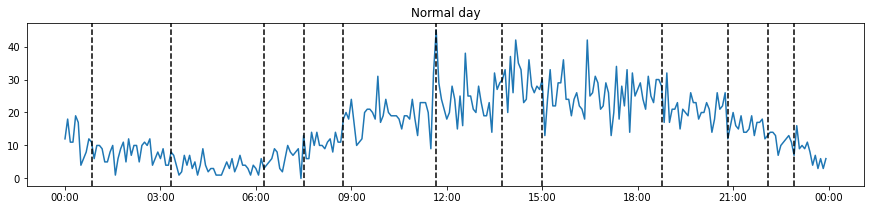

In [185]:
fig, ax = fig_ax()
ax.plot(time_index, signal)

for b in detected_bkps[:-1]:
    ax.axvline(time_index[b], ls="--", color="k")

ax.xaxis.set_major_formatter(myFmt)
_ = ax.set_title(f"{'Game day' if label==2 else 'Normal day'}")

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What do you observe?</p>
</div>

<span style="color:red"> Il essaye de trouver des bouts de courbes, le modèle de Poisson n'a pas l'air optimal. 

## Piecewise linear approximation

Instead we can use a piecewise linear approximation with continuity constraint (cost function `clinear`).

In [186]:
detected_bkps = rpt.Dynp(model="clinear").fit(signal).predict(3)

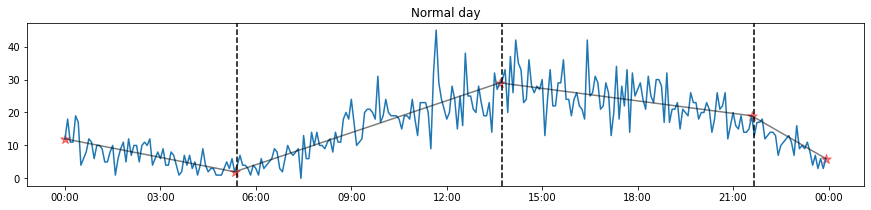

In [187]:
fig, ax = fig_ax()
ax.plot(time_index, signal)

for b in detected_bkps[:-1]:
    ax.axvline(time_index[b], ls="--", color="k")

indexes = np.r_[0, np.array(detected_bkps) - 1]
ax.plot(
    np.take(time_index, indexes),
    np.take(signal, indexes),
    color="k",
    alpha=0.5,
)
ax.scatter(
    np.take(time_index, indexes),
    np.take(signal, indexes),
    color="r",
    alpha=0.5,
    s=100,
    marker="*",
)

ax.xaxis.set_major_formatter(myFmt)
_ = ax.set_title(f"{'Game day' if label==2 else 'Normal day'}")

The associated BIC criterion is $\beta_{\text{clinear}, BIC} = 2\sigma^2\log(T)$.

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Detect changes with the BIC criterion. (Use the first 50 samples to estimate the variance.)</p>
</div>

In [188]:
pen_bic = 2 * signal[:50].var()*log(signal.shape[0])
detected_bkps = rpt.Pelt(model = "clinear").fit(signal).predict(pen = pen_bic)

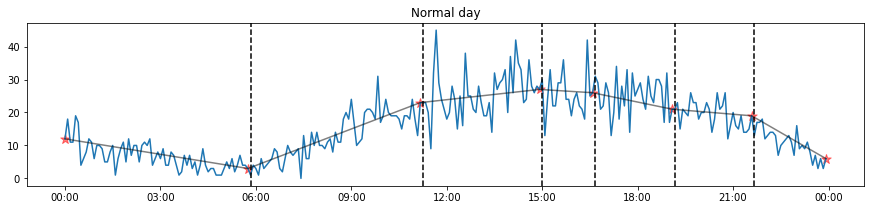

In [189]:
fig, ax = fig_ax()
ax.plot(time_index, signal)

for b in detected_bkps[:-1]:
    ax.axvline(time_index[b], ls="--", color="k")

indexes = np.r_[0, np.array(detected_bkps) - 1]
ax.plot(
    np.take(time_index, indexes),
    np.take(signal, indexes),
    color="k",
    alpha=0.5,
)
ax.scatter(
    np.take(time_index, indexes),
    np.take(signal, indexes),
    color="r",
    alpha=0.5,
    s=100,
    marker="*",
)


ax.xaxis.set_major_formatter(myFmt)
_ = ax.set_title(f"{'Game day' if label==2 else 'Normal day'}")

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What do you think of this segmentation?</p>
</div>

<span style="color:red"> C'est une bonne aproximation mais je pense qu'il y a trop de ruptures

## Supervised segmentation

To find a better regularization, we can use a few annotated examples.

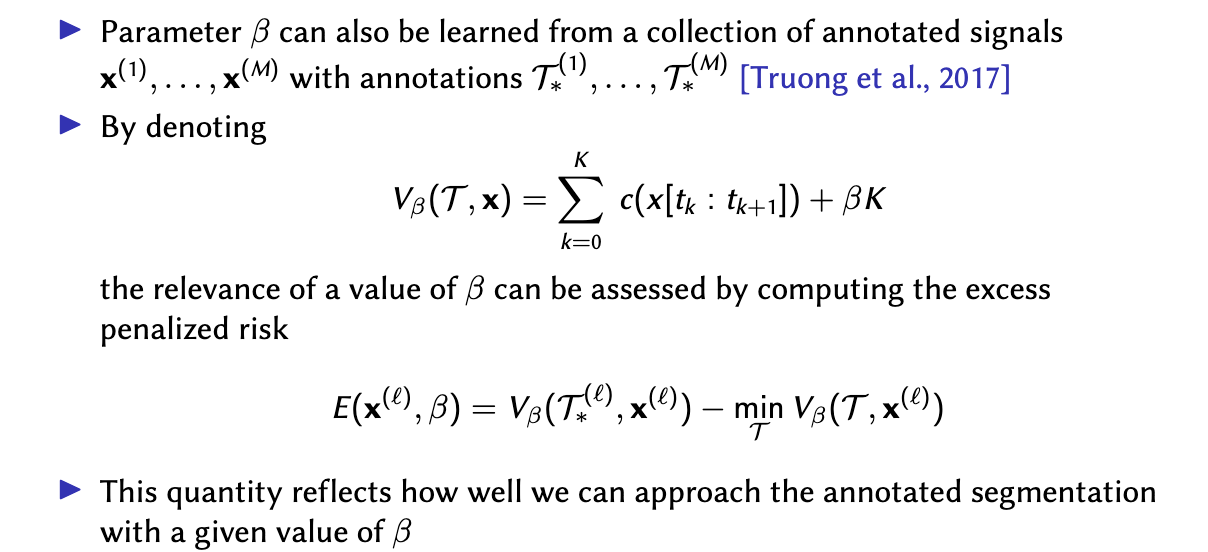

In [190]:
def loss_func(signal, annotation, pen_array=np.logspace(2, 4, 100)):
    n_samples = signal.shape[0]
    algo = rpt.Dynp(model="clinear").fit(signal)
    algo.predict(10)
    annotated_cost = algo.cost.sum_of_costs(annotation)
    cost_arr = np.array([algo.cost.sum_of_costs([n_samples])] * pen_array.size)
    for n_bkps in range(1, 11):
        detected_bkps = algo.predict(n_bkps=n_bkps)
        cost_arr = np.minimum(
            algo.cost.sum_of_costs(detected_bkps) + pen_array * n_bkps,
            cost_arr,
        )
    loss_arr = annotated_cost + pen_array * (len(annotation) - 1) - cost_arr
    return loss_arr

Annotate a few signals.

In [191]:
annotations_indexes = [0, 2, 10, 11]
n_bkps_annotated = [4, 3, 5, 4]  # manually chosen

annotation_list = list()

for (signal_index, n_bkps) in zip(annotations_indexes, n_bkps_annotated):
    signal = data.X_train[signal_index]
    detected_bkps = rpt.Dynp(model="clinear").fit_predict(
        signal=signal, n_bkps=n_bkps
    )
    annotation_list.append(detected_bkps)

Look at the annotations.

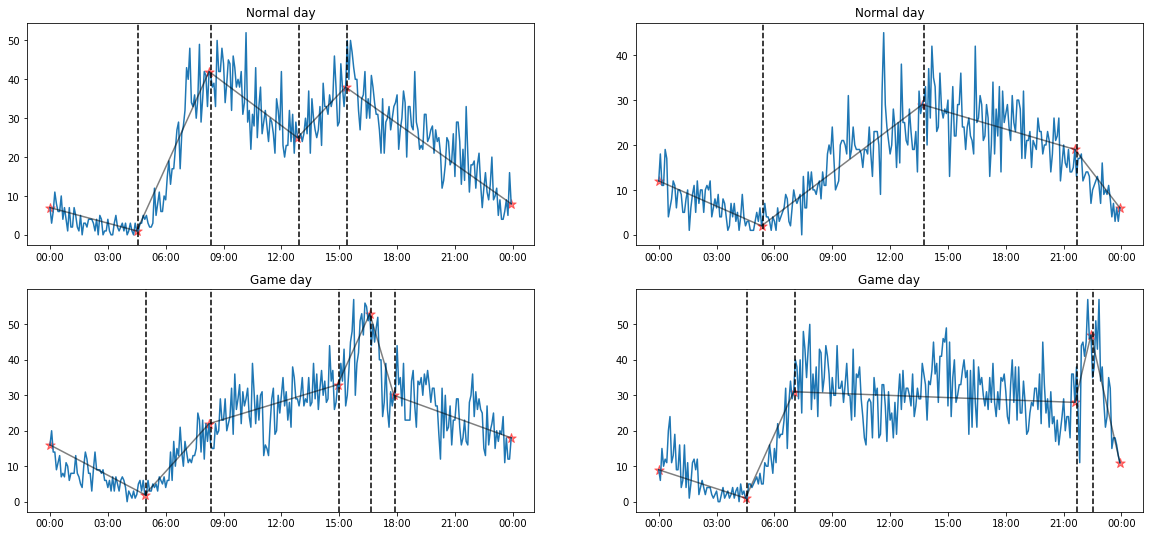

In [192]:
fig, ax_arr = plt.subplots(nrows=2, ncols=2, figsize=(20, 9))

for k, ax in enumerate(ax_arr.flatten()):
    signal = data.X_train[annotations_indexes[k]]
    label = int(data.y_train[annotations_indexes[k]])
    detected_bkps = annotation_list[k]

    # plot
    ax.plot(time_index, signal)
    # plot changes
    for b in detected_bkps[:-1]:
        ax.axvline(time_index[b], ls="--", color="k")
    # add linear approximation
    indexes = np.r_[0, np.array(detected_bkps) - 1]
    ax.plot(
        np.take(time_index, indexes),
        np.take(signal, indexes),
        color="k",
        alpha=0.5,
    )
    ax.scatter(
        np.take(time_index, indexes),
        np.take(signal, indexes),
        color="r",
        alpha=0.5,
        s=100,
        marker="*",
    )
    ax.xaxis.set_major_formatter(myFmt)
    _ = ax.set_title(f"{'Game day' if label==2 else 'Normal day'}")

Compute the loss for the manual segmentation.

In [193]:
pen_array = np.logspace(2, 3.5, 100)

loss_arr = np.zeros((pen_array.size, len(annotations_indexes)))

for (k, (signal, n_bkps)) in enumerate(
    zip(np.take(data.X_train, annotations_indexes, axis=0), n_bkps_annotated)
):
    loss_arr[:, k] = loss_func(
        signal,
        annotation_list[k],
        pen_array=pen_array,
    )

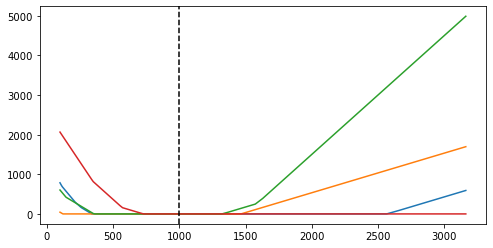

In [194]:
fig, ax = fig_ax(figsize=(8, 4))
ax.plot(pen_array, loss_arr)
pen_opt = pen_array[np.argmin(loss_arr.mean(axis=1))]
pen_opt = 1000
ax.axvline(pen_opt, color="k", ls="--")

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Using the supervised penalty value, segment all signals from the training set.</p>
    <p>Plot all piecewise linear approximations, for each class (Normal day or Game day) separately.</p>
</div>

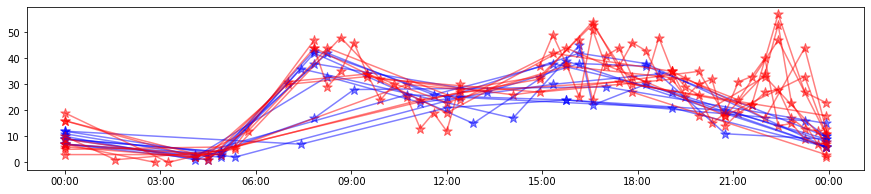

In [195]:
list_of_segmentations = list()

for signal in data.X_train: 
    detected_bkps = rpt.Pelt(model="clinear").fit(signal).predict(pen = pen_opt)
    list_of_segmentations.append(detected_bkps)
    
fig, ax = fig_ax()

for (signal, label, detected_bkps) in zip(
    data.X_train, data.y_train, list_of_segmentations
):
    color = "b" if label == "1" else "r"
    indexes = np.r_[0, np.array(detected_bkps) - 1]
    ax.plot(
        np.take(time_index, indexes),
        np.take(signal, indexes),
        color=color,
        alpha=0.5,
    )
    ax.scatter(
        np.take(time_index, indexes),
        np.take(signal, indexes),
        color=color,
        alpha=0.5,
        s=100,
        marker="*",
    )

ax.xaxis.set_major_formatter(myFmt)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>How could you use those segmentations to discriminate between the two classes?</p>
</div>

<span style="color:red">  Il suffirait de regarder les données entre 21h et Minuit. Si les données sont au dessus de 30 environ, alors on la classe en 'Game day'.